In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import numpy as np
from tqdm.auto import tqdm
from collections import defaultdict
from keras import metrics
from tabulate import tabulate
import matplotlib.pyplot as plt
from multiprocessing import Pool
from random import randint
from typing import Any, Dict, List, Sequence
import time

import numpy.typing as npt
!pip install scaaml
from scaaml.aes import ap_preds_to_key_preds
from scaaml.plot import plot_trace, plot_confusion_matrix



/opt/anaconda3/envs/DAT255_SCA_ny/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from typing import Sequence, List
import numpy.typing as npt


def pretty_hex(e: int) -> str:
    """Representation of an integer as a zero-padded two-digit hex string."""
    return f"{e:02X}"


def hex_line(chars: Sequence[int], spacer: str = " ") -> str:
    """Render some chars as hex with a spacer between them"""
    h = []
    for e in chars:
        h.append(pretty_hex(e))
    return spacer.join(h)


def hex_display(lst: Sequence[int],
                prefix: str = "",
                color: str = "green") -> None:
    """Display a list of int as colored hex."""
    h = []
    for e in lst:
        h.append(pretty_hex(e))
    hex_representation = prefix + " ".join(h)
    # Assuming you print with some styled color effect
    print(f"{color}: {hex_representation}")  # Example use of the 'color' parameter

def from_categorical(predictions: Sequence[npt.ArrayLike]) -> List[np.intp]:
    "reverse of categorical"
    # note: doing it as a list is significantly faster than a single argmax
    return [np.argmax(p) for p in predictions]
def bytelist_to_hex(lst: Sequence[int], spacer: str = " ") -> str:
    h = []

    for e in lst:
        h.append(pretty_hex(e))
    return spacer.join(h)

In [4]:
ATTACK_POINT = 'sub_bytes_in'

# let's also pick the key byte we want to use SCAAML to recover and load the related model
ATTACK_BYTE = 0

In [5]:
#no need to run as the datasets are already available
import src.DAT255_SCA.utils.dataset_utils as utils
file_path = "../datasets/testing_set.hdf5"
utils.close_file(file_path)
utils.create_dataset(file_path, 256, 256, "test")

OSError: Unable to synchronously open file (file signature not found)

In [7]:

#importing the models
from keras.models import Model
import tensorflow as tf

#model5000 = tf.keras.models.load_model("../models/stm32f0-tinyaes-cnn-v10-ap_sub_bytes_in-byte_0-len_5000.keras")
model = tf.keras.models.load_model("../models/best_model_v1.keras")
#no use for this as our data only has range 5000
#model20000 = tf.keras.models.load_model("stm32f0-tinyaes-cnn-v10-ap_sub_bytes_in-byte_0-len_20000.keras")

In [ ]:
#ignore warning for now

In [11]:
import src.DAT255_SCA.utils.dataset_utils as utils
NUM_TRACES = 10  # maximum number of traces to use to recover a given key byte. 10 is already overkill
correct_prediction_rank = defaultdict(list)
y_pred = []
y_true = []
model_metrics = {"acc": metrics.Accuracy()}
file_path = "../datasets/test/test_0.hdf5"

#for løkken må endres fordi metoden returnerer en liste av alt
#heller iterere over i, siden første plassen i listen er all info for "shard 1"
x = []
y = []
keys = []
pts = []

x, y, keys, pts = utils.load_and_prepare_dataset_for_evaluation(file_path, ATTACK_BYTE, ATTACK_POINT, num_traces=NUM_TRACES)

for i in tqdm(range(len(x)), desc='Recovering bytes', unit='shards'):

    # prediction
    predictions = model.predict(x[i])

    # computing byte prediction from intermediate predictions
    key_preds = ap_preds_to_key_preds(predictions, pts[i], ATTACK_POINT)

    c_preds = from_categorical(predictions)
    c_y = from_categorical(y[i])


    # metric tracking
    for metric in model_metrics.values():
        metric.update_state(c_y, c_preds)
    # for the confusion matrix
    y_pred.extend(c_preds)
    y_true.extend(c_y)

    # accumulating probabilities and checking correct guess position.
    # if all goes well it will be at position 0 (highest probability)
    # see below on how to use for the real attack

    key = keys[i][0] # all the same in the same shard - not used in real attack
    vals = np.zeros((256))
    for trace_count, kp in enumerate(key_preds):
        vals = vals  + np.log10(kp + 1e-22)
        guess_ranks = (np.argsort(vals, )[-256:][::-1])
        byte_rank = list(guess_ranks).index(key)
        correct_prediction_rank[trace_count].append(byte_rank)
    del predictions, key_preds, c_preds, c_y

Recovering bytes:   0%|          | 0/256 [00:00<?, ?shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Recovering bytes:   0%|          | 1/256 [00:00<01:00,  4.18shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Recovering bytes:   1%|          | 2/256 [00:00<00:54,  4.62shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Recovering bytes:   1%|          | 3/256 [00:00<00:53,  4.70shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Recovering bytes:   2%|▏         | 4/256 [00:00<00:55,  4.56shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Recovering bytes:   2%|▏         | 5/256 [00:01<00:56,  4.47shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Recovering bytes:   2%|▏         | 6/256 [00:01<00:54,  4.61shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Recovering bytes:   3%|▎         | 7/256 [00:01<00:53,  4.68shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Recovering bytes:   3%|▎         | 8/256 [00:01<00:52,  4.76shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Recovering bytes:   4%|▎         | 9/256 [00:01<00:51,  4.82shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Recovering bytes:   4%|▍         | 10/256 [00:02<00:50,  4.85shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Recovering bytes:   4%|▍         | 11/256 [00:02<00:50,  4.83shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Recovering bytes:   5%|▍         | 12/256 [00:02<00:50,  4.84shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Recovering bytes:   5%|▌         | 13/256 [00:02<00:49,  4.89shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Recovering bytes:   5%|▌         | 14/256 [00:02<00:48,  4.95shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Recovering bytes:   6%|▌         | 15/256 [00:03<00:48,  4.98shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Recovering bytes:   6%|▋         | 16/256 [00:03<00:47,  5.00shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Recovering bytes:   7%|▋         | 17/256 [00:03<00:48,  4.97shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Recovering bytes:   7%|▋         | 18/256 [00:03<00:47,  4.99shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Recovering bytes:   7%|▋         | 19/256 [00:03<00:47,  5.03shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Recovering bytes:   8%|▊         | 20/256 [00:04<00:47,  4.98shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Recovering bytes:   8%|▊         | 21/256 [00:04<00:47,  4.99shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Recovering bytes:   9%|▊         | 22/256 [00:04<00:46,  4.99shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Recovering bytes:   9%|▉         | 23/256 [00:04<00:46,  5.01shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Recovering bytes:   9%|▉         | 24/256 [00:04<00:46,  5.02shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Recovering bytes:  10%|▉         | 25/256 [00:05<00:46,  5.02shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Recovering bytes:  10%|█         | 26/256 [00:05<00:45,  5.03shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Recovering bytes:  11%|█         | 27/256 [00:05<00:45,  5.01shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Recovering bytes:  11%|█         | 28/256 [00:05<00:45,  5.02shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Recovering bytes:  11%|█▏        | 29/256 [00:05<00:45,  5.04shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Recovering bytes:  12%|█▏        | 30/256 [00:06<00:44,  5.03shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Recovering bytes:  12%|█▏        | 31/256 [00:06<00:44,  5.02shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Recovering bytes:  12%|█▎        | 32/256 [00:06<00:44,  5.02shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Recovering bytes:  13%|█▎        | 33/256 [00:06<00:44,  5.03shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Recovering bytes:  13%|█▎        | 34/256 [00:06<00:44,  4.94shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Recovering bytes:  14%|█▎        | 35/256 [00:07<00:44,  4.95shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Recovering bytes:  14%|█▍        | 36/256 [00:07<00:44,  4.97shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Recovering bytes:  14%|█▍        | 37/256 [00:07<00:44,  4.96shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Recovering bytes:  15%|█▍        | 38/256 [00:07<00:43,  5.00shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Recovering bytes:  15%|█▌        | 39/256 [00:07<00:43,  5.02shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Recovering bytes:  16%|█▌        | 40/256 [00:08<00:43,  5.00shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Recovering bytes:  16%|█▌        | 41/256 [00:08<00:42,  5.01shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Recovering bytes:  16%|█▋        | 42/256 [00:08<00:42,  4.98shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Recovering bytes:  17%|█▋        | 43/256 [00:08<00:42,  5.00shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Recovering bytes:  17%|█▋        | 44/256 [00:08<00:42,  5.02shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Recovering bytes:  18%|█▊        | 45/256 [00:09<00:43,  4.83shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Recovering bytes:  18%|█▊        | 46/256 [00:09<00:44,  4.75shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Recovering bytes:  18%|█▊        | 47/256 [00:09<00:46,  4.54shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


Recovering bytes:  19%|█▉        | 48/256 [00:09<00:50,  4.14shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Recovering bytes:  19%|█▉        | 49/256 [00:10<00:50,  4.10shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Recovering bytes:  20%|█▉        | 50/256 [00:10<00:50,  4.08shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Recovering bytes:  20%|█▉        | 51/256 [00:10<00:47,  4.27shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Recovering bytes:  20%|██        | 52/256 [00:10<00:45,  4.47shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Recovering bytes:  21%|██        | 53/256 [00:11<00:44,  4.52shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Recovering bytes:  21%|██        | 54/256 [00:11<00:43,  4.63shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Recovering bytes:  21%|██▏       | 55/256 [00:11<00:42,  4.73shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Recovering bytes:  22%|██▏       | 56/256 [00:11<00:42,  4.66shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Recovering bytes:  22%|██▏       | 57/256 [00:11<00:43,  4.58shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Recovering bytes:  23%|██▎       | 58/256 [00:12<00:44,  4.48shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Recovering bytes:  23%|██▎       | 59/256 [00:12<00:43,  4.55shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Recovering bytes:  23%|██▎       | 60/256 [00:12<00:41,  4.67shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Recovering bytes:  24%|██▍       | 61/256 [00:12<00:42,  4.64shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Recovering bytes:  24%|██▍       | 62/256 [00:12<00:42,  4.53shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Recovering bytes:  25%|██▍       | 63/256 [00:13<00:43,  4.48shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Recovering bytes:  25%|██▌       | 64/256 [00:13<00:42,  4.47shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Recovering bytes:  25%|██▌       | 65/256 [00:13<00:43,  4.36shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Recovering bytes:  26%|██▌       | 66/256 [00:13<00:43,  4.36shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


Recovering bytes:  26%|██▌       | 67/256 [00:14<00:46,  4.02shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Recovering bytes:  27%|██▋       | 68/256 [00:14<00:45,  4.11shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Recovering bytes:  27%|██▋       | 69/256 [00:14<00:44,  4.22shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Recovering bytes:  27%|██▋       | 70/256 [00:14<00:42,  4.35shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Recovering bytes:  28%|██▊       | 71/256 [00:15<00:41,  4.41shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Recovering bytes:  28%|██▊       | 72/256 [00:15<00:40,  4.49shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Recovering bytes:  29%|██▊       | 73/256 [00:15<00:40,  4.54shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Recovering bytes:  29%|██▉       | 74/256 [00:15<00:39,  4.59shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Recovering bytes:  29%|██▉       | 75/256 [00:15<00:39,  4.59shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Recovering bytes:  30%|██▉       | 76/256 [00:16<00:39,  4.52shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Recovering bytes:  30%|███       | 77/256 [00:16<00:40,  4.46shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Recovering bytes:  30%|███       | 78/256 [00:16<00:38,  4.59shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Recovering bytes:  31%|███       | 79/256 [00:16<00:37,  4.69shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Recovering bytes:  31%|███▏      | 80/256 [00:17<00:37,  4.74shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Recovering bytes:  32%|███▏      | 81/256 [00:17<00:37,  4.64shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Recovering bytes:  32%|███▏      | 82/256 [00:17<00:37,  4.66shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Recovering bytes:  32%|███▏      | 83/256 [00:17<00:36,  4.74shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Recovering bytes:  33%|███▎      | 84/256 [00:17<00:36,  4.68shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Recovering bytes:  33%|███▎      | 85/256 [00:18<00:35,  4.76shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Recovering bytes:  34%|███▎      | 86/256 [00:18<00:35,  4.72shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Recovering bytes:  34%|███▍      | 87/256 [00:18<00:35,  4.77shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Recovering bytes:  34%|███▍      | 88/256 [00:18<00:34,  4.85shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Recovering bytes:  35%|███▍      | 89/256 [00:18<00:34,  4.88shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Recovering bytes:  35%|███▌      | 90/256 [00:19<00:33,  4.90shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Recovering bytes:  36%|███▌      | 91/256 [00:19<00:33,  4.88shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Recovering bytes:  36%|███▌      | 92/256 [00:19<00:33,  4.87shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Recovering bytes:  36%|███▋      | 93/256 [00:19<00:33,  4.90shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Recovering bytes:  37%|███▋      | 94/256 [00:19<00:33,  4.91shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Recovering bytes:  37%|███▋      | 95/256 [00:20<00:33,  4.82shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Recovering bytes:  38%|███▊      | 96/256 [00:20<00:34,  4.70shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Recovering bytes:  38%|███▊      | 97/256 [00:20<00:34,  4.65shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Recovering bytes:  38%|███▊      | 98/256 [00:20<00:34,  4.61shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Recovering bytes:  39%|███▊      | 99/256 [00:21<00:34,  4.60shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Recovering bytes:  39%|███▉      | 100/256 [00:21<00:33,  4.68shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Recovering bytes:  39%|███▉      | 101/256 [00:21<00:33,  4.59shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Recovering bytes:  40%|███▉      | 102/256 [00:21<00:32,  4.70shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Recovering bytes:  40%|████      | 103/256 [00:21<00:32,  4.65shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Recovering bytes:  41%|████      | 104/256 [00:22<00:32,  4.64shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Recovering bytes:  41%|████      | 105/256 [00:22<00:31,  4.75shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Recovering bytes:  41%|████▏     | 106/256 [00:22<00:31,  4.78shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Recovering bytes:  42%|████▏     | 107/256 [00:22<00:30,  4.84shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Recovering bytes:  42%|████▏     | 108/256 [00:22<00:30,  4.86shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Recovering bytes:  43%|████▎     | 109/256 [00:23<00:30,  4.79shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Recovering bytes:  43%|████▎     | 110/256 [00:23<00:30,  4.73shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Recovering bytes:  43%|████▎     | 111/256 [00:23<00:31,  4.64shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Recovering bytes:  44%|████▍     | 112/256 [00:23<00:31,  4.62shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Recovering bytes:  44%|████▍     | 113/256 [00:24<00:31,  4.52shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Recovering bytes:  45%|████▍     | 114/256 [00:24<00:31,  4.52shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Recovering bytes:  45%|████▍     | 115/256 [00:24<00:32,  4.35shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Recovering bytes:  45%|████▌     | 116/256 [00:24<00:32,  4.33shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Recovering bytes:  46%|████▌     | 117/256 [00:24<00:32,  4.32shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Recovering bytes:  46%|████▌     | 118/256 [00:25<00:32,  4.28shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Recovering bytes:  46%|████▋     | 119/256 [00:25<00:31,  4.28shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Recovering bytes:  47%|████▋     | 120/256 [00:25<00:31,  4.26shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Recovering bytes:  47%|████▋     | 121/256 [00:25<00:31,  4.29shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


Recovering bytes:  48%|████▊     | 122/256 [00:26<00:34,  3.92shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Recovering bytes:  48%|████▊     | 123/256 [00:26<00:32,  4.15shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Recovering bytes:  48%|████▊     | 124/256 [00:26<00:30,  4.31shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Recovering bytes:  49%|████▉     | 125/256 [00:26<00:30,  4.30shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Recovering bytes:  49%|████▉     | 126/256 [00:27<00:29,  4.34shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Recovering bytes:  50%|████▉     | 127/256 [00:27<00:29,  4.38shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Recovering bytes:  50%|█████     | 128/256 [00:27<00:28,  4.48shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Recovering bytes:  50%|█████     | 129/256 [00:27<00:27,  4.57shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Recovering bytes:  51%|█████     | 130/256 [00:27<00:26,  4.69shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Recovering bytes:  51%|█████     | 131/256 [00:28<00:26,  4.68shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Recovering bytes:  52%|█████▏    | 132/256 [00:28<00:26,  4.76shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Recovering bytes:  52%|█████▏    | 133/256 [00:28<00:25,  4.80shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Recovering bytes:  52%|█████▏    | 134/256 [00:28<00:25,  4.83shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Recovering bytes:  53%|█████▎    | 135/256 [00:28<00:24,  4.86shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Recovering bytes:  53%|█████▎    | 136/256 [00:29<00:24,  4.84shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Recovering bytes:  54%|█████▎    | 137/256 [00:29<00:24,  4.87shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Recovering bytes:  54%|█████▍    | 138/256 [00:29<00:24,  4.88shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Recovering bytes:  54%|█████▍    | 139/256 [00:29<00:23,  4.88shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Recovering bytes:  55%|█████▍    | 140/256 [00:29<00:23,  4.89shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Recovering bytes:  55%|█████▌    | 141/256 [00:30<00:23,  4.87shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Recovering bytes:  55%|█████▌    | 142/256 [00:30<00:23,  4.81shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Recovering bytes:  56%|█████▌    | 143/256 [00:30<00:23,  4.80shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Recovering bytes:  56%|█████▋    | 144/256 [00:30<00:23,  4.83shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Recovering bytes:  57%|█████▋    | 145/256 [00:30<00:22,  4.88shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Recovering bytes:  57%|█████▋    | 146/256 [00:31<00:22,  4.88shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Recovering bytes:  57%|█████▋    | 147/256 [00:31<00:22,  4.90shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Recovering bytes:  58%|█████▊    | 148/256 [00:31<00:22,  4.88shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Recovering bytes:  58%|█████▊    | 149/256 [00:31<00:21,  4.90shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Recovering bytes:  59%|█████▊    | 150/256 [00:32<00:21,  4.91shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Recovering bytes:  59%|█████▉    | 151/256 [00:32<00:21,  4.85shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Recovering bytes:  59%|█████▉    | 152/256 [00:32<00:21,  4.88shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Recovering bytes:  60%|█████▉    | 153/256 [00:32<00:20,  4.91shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Recovering bytes:  60%|██████    | 154/256 [00:32<00:20,  4.91shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Recovering bytes:  61%|██████    | 155/256 [00:33<00:20,  4.93shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Recovering bytes:  61%|██████    | 156/256 [00:33<00:20,  4.89shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Recovering bytes:  61%|██████▏   | 157/256 [00:33<00:20,  4.90shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Recovering bytes:  62%|██████▏   | 158/256 [00:33<00:20,  4.89shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Recovering bytes:  62%|██████▏   | 159/256 [00:33<00:19,  4.92shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Recovering bytes:  62%|██████▎   | 160/256 [00:34<00:19,  4.90shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Recovering bytes:  63%|██████▎   | 161/256 [00:34<00:19,  4.88shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Recovering bytes:  63%|██████▎   | 162/256 [00:34<00:19,  4.91shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Recovering bytes:  64%|██████▎   | 163/256 [00:34<00:19,  4.86shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Recovering bytes:  64%|██████▍   | 164/256 [00:34<00:18,  4.86shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Recovering bytes:  64%|██████▍   | 165/256 [00:35<00:18,  4.89shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Recovering bytes:  65%|██████▍   | 166/256 [00:35<00:18,  4.85shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Recovering bytes:  65%|██████▌   | 167/256 [00:35<00:18,  4.87shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Recovering bytes:  66%|██████▌   | 168/256 [00:35<00:18,  4.88shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Recovering bytes:  66%|██████▌   | 169/256 [00:35<00:17,  4.85shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Recovering bytes:  66%|██████▋   | 170/256 [00:36<00:17,  4.87shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Recovering bytes:  67%|██████▋   | 171/256 [00:36<00:17,  4.86shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Recovering bytes:  67%|██████▋   | 172/256 [00:36<00:17,  4.87shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Recovering bytes:  68%|██████▊   | 173/256 [00:36<00:17,  4.87shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Recovering bytes:  68%|██████▊   | 174/256 [00:36<00:16,  4.87shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Recovering bytes:  68%|██████▊   | 175/256 [00:37<00:16,  4.88shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Recovering bytes:  69%|██████▉   | 176/256 [00:37<00:16,  4.85shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Recovering bytes:  69%|██████▉   | 177/256 [00:37<00:16,  4.85shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


Recovering bytes:  70%|██████▉   | 178/256 [00:37<00:19,  3.94shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


Recovering bytes:  70%|██████▉   | 179/256 [00:38<00:21,  3.61shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


Recovering bytes:  70%|███████   | 180/256 [00:38<00:22,  3.44shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Recovering bytes:  71%|███████   | 181/256 [00:38<00:19,  3.77shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Recovering bytes:  71%|███████   | 182/256 [00:38<00:18,  4.01shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Recovering bytes:  71%|███████▏  | 183/256 [00:39<00:17,  4.24shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Recovering bytes:  72%|███████▏  | 184/256 [00:39<00:16,  4.38shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Recovering bytes:  72%|███████▏  | 185/256 [00:39<00:15,  4.53shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Recovering bytes:  73%|███████▎  | 186/256 [00:39<00:15,  4.66shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Recovering bytes:  73%|███████▎  | 187/256 [00:40<00:14,  4.68shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Recovering bytes:  73%|███████▎  | 188/256 [00:40<00:14,  4.76shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Recovering bytes:  74%|███████▍  | 189/256 [00:40<00:14,  4.71shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Recovering bytes:  74%|███████▍  | 190/256 [00:40<00:13,  4.75shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Recovering bytes:  75%|███████▍  | 191/256 [00:40<00:13,  4.78shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Recovering bytes:  75%|███████▌  | 192/256 [00:41<00:13,  4.77shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Recovering bytes:  75%|███████▌  | 193/256 [00:41<00:13,  4.64shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Recovering bytes:  76%|███████▌  | 194/256 [00:41<00:13,  4.55shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Recovering bytes:  76%|███████▌  | 195/256 [00:41<00:13,  4.45shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Recovering bytes:  77%|███████▋  | 196/256 [00:42<00:14,  4.27shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Recovering bytes:  77%|███████▋  | 197/256 [00:42<00:13,  4.34shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Recovering bytes:  77%|███████▋  | 198/256 [00:42<00:12,  4.50shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Recovering bytes:  78%|███████▊  | 199/256 [00:42<00:12,  4.63shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Recovering bytes:  78%|███████▊  | 200/256 [00:42<00:11,  4.75shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Recovering bytes:  79%|███████▊  | 201/256 [00:43<00:11,  4.75shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Recovering bytes:  79%|███████▉  | 202/256 [00:43<00:11,  4.67shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Recovering bytes:  79%|███████▉  | 203/256 [00:43<00:11,  4.60shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Recovering bytes:  80%|███████▉  | 204/256 [00:43<00:11,  4.68shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Recovering bytes:  80%|████████  | 205/256 [00:43<00:10,  4.77shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Recovering bytes:  80%|████████  | 206/256 [00:44<00:10,  4.79shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Recovering bytes:  81%|████████  | 207/256 [00:44<00:10,  4.84shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Recovering bytes:  81%|████████▏ | 208/256 [00:44<00:10,  4.79shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Recovering bytes:  82%|████████▏ | 209/256 [00:44<00:09,  4.83shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Recovering bytes:  82%|████████▏ | 210/256 [00:44<00:09,  4.83shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Recovering bytes:  82%|████████▏ | 211/256 [00:45<00:09,  4.74shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Recovering bytes:  83%|████████▎ | 212/256 [00:45<00:09,  4.80shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Recovering bytes:  83%|████████▎ | 213/256 [00:45<00:08,  4.80shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Recovering bytes:  84%|████████▎ | 214/256 [00:45<00:08,  4.84shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Recovering bytes:  84%|████████▍ | 215/256 [00:45<00:08,  4.81shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Recovering bytes:  84%|████████▍ | 216/256 [00:46<00:08,  4.84shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Recovering bytes:  85%|████████▍ | 217/256 [00:46<00:07,  4.88shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Recovering bytes:  85%|████████▌ | 218/256 [00:46<00:07,  4.86shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Recovering bytes:  86%|████████▌ | 219/256 [00:46<00:07,  4.83shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Recovering bytes:  86%|████████▌ | 220/256 [00:47<00:07,  4.81shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


Recovering bytes:  86%|████████▋ | 221/256 [00:47<00:07,  4.41shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Recovering bytes:  87%|████████▋ | 222/256 [00:47<00:07,  4.51shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Recovering bytes:  87%|████████▋ | 223/256 [00:47<00:07,  4.58shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Recovering bytes:  88%|████████▊ | 224/256 [00:47<00:06,  4.70shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Recovering bytes:  88%|████████▊ | 225/256 [00:48<00:06,  4.67shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Recovering bytes:  88%|████████▊ | 226/256 [00:48<00:06,  4.74shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Recovering bytes:  89%|████████▊ | 227/256 [00:48<00:06,  4.74shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Recovering bytes:  89%|████████▉ | 228/256 [00:48<00:05,  4.74shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Recovering bytes:  89%|████████▉ | 229/256 [00:48<00:05,  4.80shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Recovering bytes:  90%|████████▉ | 230/256 [00:49<00:05,  4.80shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Recovering bytes:  90%|█████████ | 231/256 [00:49<00:05,  4.80shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Recovering bytes:  91%|█████████ | 232/256 [00:49<00:04,  4.83shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Recovering bytes:  91%|█████████ | 233/256 [00:49<00:04,  4.81shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Recovering bytes:  91%|█████████▏| 234/256 [00:49<00:04,  4.84shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Recovering bytes:  92%|█████████▏| 235/256 [00:50<00:04,  4.82shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Recovering bytes:  92%|█████████▏| 236/256 [00:50<00:04,  4.86shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Recovering bytes:  93%|█████████▎| 237/256 [00:50<00:03,  4.83shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Recovering bytes:  93%|█████████▎| 238/256 [00:50<00:03,  4.82shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Recovering bytes:  93%|█████████▎| 239/256 [00:51<00:03,  4.81shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Recovering bytes:  94%|█████████▍| 240/256 [00:51<00:03,  4.78shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Recovering bytes:  94%|█████████▍| 241/256 [00:51<00:03,  4.82shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Recovering bytes:  95%|█████████▍| 242/256 [00:51<00:02,  4.80shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Recovering bytes:  95%|█████████▍| 243/256 [00:51<00:02,  4.81shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Recovering bytes:  95%|█████████▌| 244/256 [00:52<00:02,  4.84shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Recovering bytes:  96%|█████████▌| 245/256 [00:52<00:02,  4.75shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Recovering bytes:  96%|█████████▌| 246/256 [00:52<00:02,  4.75shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Recovering bytes:  96%|█████████▋| 247/256 [00:52<00:01,  4.73shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Recovering bytes:  97%|█████████▋| 248/256 [00:52<00:01,  4.74shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Recovering bytes:  97%|█████████▋| 249/256 [00:53<00:01,  4.75shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Recovering bytes:  98%|█████████▊| 250/256 [00:53<00:01,  4.76shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Recovering bytes:  98%|█████████▊| 251/256 [00:53<00:01,  4.75shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Recovering bytes:  98%|█████████▊| 252/256 [00:53<00:00,  4.76shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Recovering bytes:  99%|█████████▉| 253/256 [00:53<00:00,  4.77shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Recovering bytes:  99%|█████████▉| 254/256 [00:54<00:00,  4.74shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Recovering bytes: 100%|█████████▉| 255/256 [00:54<00:00,  4.73shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Recovering bytes: 100%|██████████| 256/256 [00:54<00:00,  4.69shards/s]


In [12]:
print("Accuracy: %.2f" % model_metrics['acc'].result())


Accuracy: 0.54


/opt/anaconda3/envs/DAT255_SCA_ny/lib/python3.12/site-packages/scaaml/plot.py:169: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]


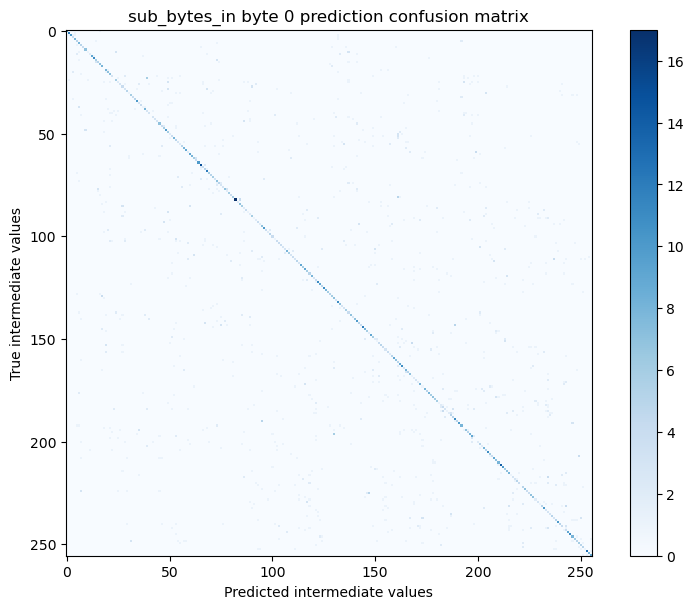

In [13]:
plot_confusion_matrix(y_true, y_pred, normalize=True, title="%s byte %s prediction confusion matrix" % (ATTACK_POINT, ATTACK_BYTE))


In [14]:
config = """{
    "model": "cnn",
    "device": "stm32f0",
    "algorithm": "tinyaes",
    "version": "1",
    "attack_points": [
        "sub_bytes_in"
    ],
    "attack_bytes": [
        "0"
    ],
    "max_trace_len": 5000,
    "num_shards": 256,
    "num_traces_per_shard": 256,
    "batch_size": 32,
    "epochs": 30,
    "optimizer_parameters": {
        "lr": 0.00010283965194405868,
        "multi_gpu_lr": null
    },
    "model_parameters": {
        "activation": "tanh",
        "initial_filters": 8,
        "initial_pool_size": 2,
        "block_kernel_size": 13,
        "blocks_stack1": 6,
        "blocks_stack2": 2,
        "blocks_stack3": 5,
        "blocks_stack4": 6,
        "dense_dropout": 0.45,
        "use_pooling": false
    }
}"""
target_config = json.loads(config)


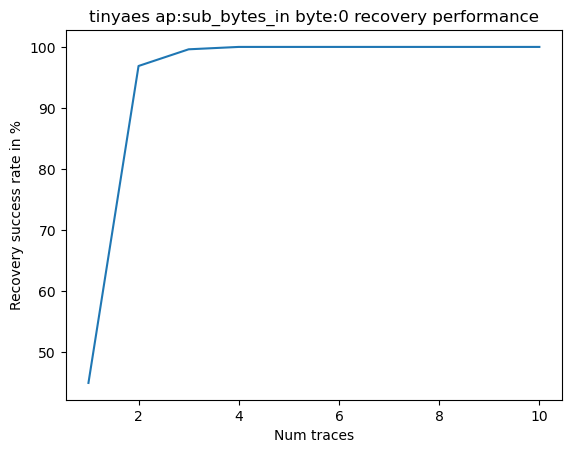

In [15]:
NUM_TRACES_TO_PLOT = 10
avg_preds = np.array([correct_prediction_rank[i].count(0) for i in range(NUM_TRACES_TO_PLOT)])
y = avg_preds / len(correct_prediction_rank[0]) * 100
x = [i + 1 for i in range(NUM_TRACES_TO_PLOT)]
plt.plot(x, y)
plt.xlabel("Num traces")
plt.ylabel("Recovery success rate in %")
plt.title("%s ap:%s byte:%s recovery performance" % (target_config['algorithm'], ATTACK_POINT, ATTACK_BYTE))
plt.show()

In [16]:
min_traces = 0
max_traces = 0
cumulative_aa = 0
for idx, val in enumerate(y):
    cumulative_aa += val
    if not min_traces and val > 0:
        min_traces = idx + 1
    if not max_traces and val == 100.0:
        max_traces = idx + 1
        break

cumulative_aa = round( cumulative_aa / (idx + 1), 2) # divide by the number of steps

rows = [
    ["min traces", min_traces, round(y[min_traces -1 ], 1)],
    ["max traces", max_traces, round(y[max_traces - 1], 1)],
    ["cumulative score", cumulative_aa, '-']
]
print(tabulate(rows, headers=['metric', 'num traces', '% of keys']))

metric              num traces  % of keys
----------------  ------------  -----------
min traces                1     44.9
max traces                4     100.0
cumulative score         85.35  -


In [64]:
ATTACK_POINT = 'sub_bytes_in' # let's pick an attack point- Key is not a good target: it doesn't work for TinyAEs
TARGET_SHARD = 36 # a shard == a different key. Pick the one you would like
NUM_TRACES = 1  # how many traces to use - as seen in single byte, 5 traces is enough

DEMONSTRERER AT MODELLEN IKKE KAN GENERALISERE TIL ANDRE BYTES

In [65]:
real_key = []  # Hva vi skal finne
recovered_key = []  # Hva vi predikerer

pb = tqdm(total=1, desc="Guessing key", unit='guesses')
#å endre filepath fører til at vi må inn igjen i hdf5 filen og hente riktig shard



for ATTACK_BYTE in range(1):
    #pain at denne henter alt for hver gang
    x, y, keys, pts = utils.load_and_prepare_dataset_for_evaluation(file_path, ATTACK_BYTE, ATTACK_POINT, num_traces=NUM_TRACES)
    #funker det om den peker på -1 FÅR JO IKKE HENTET HELE NØKKELEN FOR HELVETE; IKKE AT DET HAR NOE FUNKSJONELT Å SI PÅ DENNE
    real_key.append(keys[TARGET_SHARD][ATTACK_BYTE])

    #trace er jo det samme
    x = x[TARGET_SHARD]
    print(x.shape)

    # Prediksjon
    predictions = model.predict(x)

    # Beregn byte-prediksjon fra de mellomliggende prediksjonene
    key_preds = ap_preds_to_key_preds(predictions, pts[TARGET_SHARD], ATTACK_POINT)

    # Akkumulering av sannsynlighet (logaritmisk skala for stabilitet)
    vals = np.zeros((256,))
    for trace_count, kp in enumerate(key_preds):
        vals += np.log10(kp + 1e-22)

    # Sorter prediksjoner etter sannsynlighet (de sterkeste først)
    guess_ranks = np.argsort(vals)[::-1]

    # Ta den sterkeste gjetningen som vårt predikerte nøkkelbyte
    recovered_key.append(guess_ranks[0])

    # Oppdater fremdriftslinje (tqdm)
    pb.set_postfix({
        'Recovered key': bytelist_to_hex(recovered_key),
        'Real key': bytelist_to_hex(real_key)
    })
    pb.update()

pb.close()


Guessing key:   0%|          | 0/1 [00:00<?, ?guesses/s]

(1, 5000, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Guessing key: 100%|██████████| 1/1 [00:00<00:00,  2.94guesses/s, Recovered key=82, Real key=82]
